# Final Project Report

## Group Members

1. Gokul Anantha Narayanan - Section 4
2. Raghavan Renganathan - Section 5

## Dog-Breed classification using pre-trained models

We have used pre-trained models to identify the breed of a dog given an image. The following are the pre-trained models that we have used to obtain the bottleneck features.

1. ResNet50
2. VGG16
3. Xception
4. Inception V3

The dataset used is [Stanford dogs dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) and it has 120 breeds. For simplyfying the training process, we have used __16 most frequent dog breeds__.

### Importing python libraries

In [1]:
import sys
from os.path import expanduser
sys.path.append(expanduser("~") + "/.local/lib/python3.5/site-packages")

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [3]:
start = dt.datetime.now()

### Defining constants

In [4]:
INPUT_SIZE = 224
NUM_CLASSES = 15
SEED = 1987
DATA_DIR = "../data"

In [5]:
labels = pd.read_csv(join(DATA_DIR, 'labels.csv'))

In [6]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [7]:
def read_images(img_id, type_of_data, size):
    img = image.load_img(join(DATA_DIR, type_of_data, "%s.jpg" % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

### ResNet50 pre-trained model

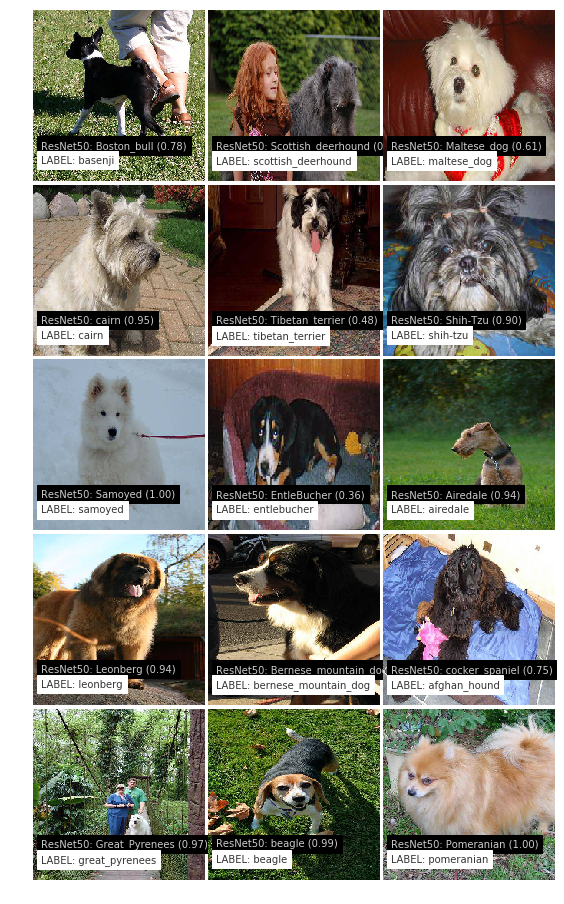

In [9]:
model = ResNet50(weights='imagenet')
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_images(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

### VGG16 pre-trained model

In [8]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_images(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1672it [00:15, 105.04it/s]

Train Images shape: (1672, 224, 224, 3) size: 251,682,816


In [9]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

((1322, 224, 224, 3), (350, 224, 224, 3), (1322, 15), (350, 15))
350/350 [==============================] - 8s 22ms/step
VGG train bottleneck features shape: (1322, 512) size: 676,864
VGG valid bottleneck features shape: (350, 512) size: 179,200


In [10]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

In [11]:
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation VGG LogLoss 0.8095189723318948
Validation VGG Accuracy 0.8542857142857143


### Xception pre-trained model

In [8]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_images(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1672it [00:10, 165.06it/s]

Train Images shape: (1672, 299, 299, 3) size: 448,435,416


In [9]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1322, 299, 299, 3), (350, 299, 299, 3), (1322, 15), (350, 15))
350/350 [==============================] - 10s 30ms/step
Xception train bottleneck features shape: (1322, 2048) size: 2,707,456
Xception valid bottleneck features shape: (350, 2048) size: 716,800


In [10]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.14292417367457708
Validation Xception Accuracy 0.98


### Inception v3 pre-trained model

In [11]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

((1322, 299, 299, 3), (350, 299, 299, 3), (1322, 15), (350, 15))
350/350 [==============================] - 7s 21ms/step
InceptionV3 train bottleneck features shape: (1322, 2048) size: 2,707,456
InceptionV3 valid bottleneck features shape: (350, 2048) size: 716,800


In [12]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

In [13]:
print('Validation Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Inception LogLoss 0.309484858488003
Validation Inception Accuracy 0.9


## Work in progress

We are working on creating a convolution network from the scratch to get a comparable accuracy with the pre-trained models.

__
Input layer: (224, 224, 3)<br>
<br>
1st Convolution Layer: 64 filters of size 5x5<br>
1st Pooling Layer: 3x3 filter with a stride of 2<br>
<br>
2nd Convolution Layer: 64 filters of size 5x5<br>
<br>
3rd Convolution Layer: 64 filters of size 5x5<br>
2nd Pooling Layer: 3x3 filter with a stride of 2<br>
<br>
1st Dense Layer: RELU activated layer<br>
2nd Dense Layer: RELU activated layer<br>
3rd Dense Layer: Softmax : 120 neurons (One for each class)<br>
__

### Processes Involved:

* Image Augmentation
* Cropping the images such that it will have only the dog's face in it
* Constructing custom made convolution neural network

### What's done?

* The data which specifies the bounding box is obtained from the standford's website
* By parsing the xml file, the images in the dataset are cropped to have only the dog's face in it
* The images are then converted into a 4-D tensor and are used for training the model
* The convolution model is built

### What's yet to do?

* Train the model with the images
* Cross-validate the model with the test dataset
* Fine tune the hyper-parameter to increase the accuracy

### Planning to do

* Creating a small webpage, where one can upload a dog's image and have it classfied

### Files

* [Reading and parsing the inputs](https://github.com/raghavan-renganathan/dog-breed-classifier/blob/master/tailoredImplementation/read_input.py)
* [Creating the cnn model](https://github.com/raghavan-renganathan/dog-breed-classifier/blob/master/tailoredImplementation/build_model.py)
* [Training the model](https://github.com/raghavan-renganathan/dog-breed-classifier/blob/master/tailoredImplementation/train_model.py) -> Yet to train the model
* [Evaluate the model](https://github.com/raghavan-renganathan/dog-breed-classifier/blob/master/tailoredImplementation/eval_model.py) -> Yet to perform evaluation